# Bike Ride Data Study

(Written as a capstone project for the [Google Data Analytics Professional Certificate](https://www.coursera.org/professional-certificates/google-data-analytics).)

In [1]:
import csv
from collections import defaultdict
from datetime import datetime
from math import radians
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import requests
%pip install seaborn
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

%pip install duckdb
import duckdb
from duckdb.typing import *

%pip install jupysql duckdb-engine --quiet
%load_ext sql

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Problem

The company needs to drive future growth by maximizing the number of annual members by selling memberships to our casual users (customers who buy single-ride or day passes).


### Business Task

Identify differences between annual members and casual users (customers who buy single-ride or day passes) in order to inform a marketing campaign aimed at selling memberships to our casual users.

### Data Sources

Twelve monthly files covering the entirety of the year 2023. The files contain the folowing fields:

* *ride_id*: Primary key. Seems to be a randomly-generated hexadecimal, but as long as the IDs are unique, it doesn't really matter how they were generated.
* *rideable_type:* "electric_bike", "classic_bike" or "docked_bike". 
* *started_at* and *ended_at*: The start and end times of the ride.
* *start_station_name* and *end_station_name*

#### Notes

We can see the time, duration, and start and end points of every ride taken by our users, as well as the kind of bike used, and whether the rider was a casual user or a member. This should be adequate to let us see some relevant differences between our two classes of users.

#### Issues

1. Some observations lack start and/or end locations.
1. Rides aren't linked to individual members--we can tell whether a given ride was taken by a member or casual user, but we can't track a single user's rides.
1. Some ride durations seem improbably long. Some have start times that are earlier than their end times.

#### Tools

I'll be using [Python](https://www.python.org/) in this [Jupyter](https://jupyter.org/) notebook, along with [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) for visualization, and [DuckDB](https://duckdb.org/) for data storage and management. I chose Python due to my familiarity with it, and DuckDB because it's a technology I'm interested in learning, and that lets me leverage my existing SQL skill.

### Process
#### Importing data:

1. Download all the monthly CSVs for 2023 and unzip them. Then read each file, calculate the distance between the start and end stations for each trip using the [Haversine formula](https://www.igismap.com/haversine-formula-calculate-geographic-distance-earth/), and save new files with the original data plus the distance (I found it's faster to do this now than in the database later).

In [2]:
KAGGLE = Path('/kaggle').exists()

if KAGGLE:
    INPUT_PATH = Path('/kaggle/input')
    WORKING_PATH = Path('/kaggle/working')
else:
    INPUT_PATH = Path('./data')
    WORKING_PATH = Path('./work')

In [3]:
def dist(start_lat, start_lng, end_lat, end_lng):
    """
    Calculate the distance between the start and end points using
    the Haversine method.
    """
    if start_lat is None or end_lat is None or start_lat == 0 or end_lat == 0:
        return None
    x = (radians(start_lat), radians(start_lng))
    y = (radians(end_lat), radians(end_lng))
    hav = haversine_distances([x, y])
    return round(hav[0,1] * 6371 * 1000, 2)

In [4]:
for x in range(1, 13):
    zipfn = "2023{:02}-divvy-tripdata.zip".format(x)
    csvfn = "2023{:02}-divvy-tripdata.csv".format(x)

    #https://divvy-tripdata.s3.amazonaws.com/202301-divvy-tripdata.zip
    fn = "2023{:02}-divvy-tripdata.zip".format(x)
    if not Path(INPUT_PATH / zipfn).exists():
        url = 'https://divvy-tripdata.s3.amazonaws.com/'+fn
        r = requests.get(url, allow_redirects=True)
        Path(INPUT_PATH / zipfn).open('wb').write(r.content)
    
    if not Path(INPUT_PATH / csvfn).exists():
        with ZipFile(INPUT_PATH / zipfn) as z:
            z.extract(csvfn, path=INPUT_PATH)

    if not Path(WORKING_PATH / csvfn).exists():
        with Path(INPUT_PATH / csvfn).open('r') as inpf, \
                Path(WORKING_PATH / csvfn).open('w', newline='') as outpf:
            ridesrdr, rideswtr = (csv.reader(inpf), csv.writer(outpf))

            headers = ridesrdr.__next__()
            headers.append('distance')
            rideswtr.writerow(headers)
            print(f"Wrote headers to {csvfn}.")
            
            for i, row in enumerate(ridesrdr):
                try:
                    row.append(dist(float(row[8]), float(row[9]), float(row[10]), float(row[11])))
                except:
                    row.append(None)
                rideswtr.writerow(row)
                if i % 250000 == 0:
                    print(f"Line {i} of file {csvfn} written.")
            print(f"File {csvfn} written ({i} lines).")

2. Create a new DuckDB table and load the 2023 ride data into it.

In [5]:
con = duckdb.connect(str(WORKING_PATH / 'rides-2023.db'))

In [6]:
%sql con
%config SqlMagic.displaylimit = 20

In [7]:
%%sql
CREATE TABLE IF NOT EXISTS rides (
    ride_id VARCHAR, 
    rideable_type VARCHAR, 
    started_at TIMESTAMP, 
    ended_at TIMESTAMP,
    start_station_name VARCHAR, 
    start_station_id VARCHAR, 
    end_station_name VARCHAR, 
    end_station_id VARCHAR, 
    start_lat DOUBLE, 
    start_lng DOUBLE, 
    end_lat DOUBLE, 
    end_lng DOUBLE, 
    member_casual VARCHAR, 
    distance DOUBLE, 
    duration INTERVAL, 
    duration_minutes INTEGER, 
    duration_seconds INTEGER,
    ride_weekday INTEGER, 
    ride_month INTEGER, 
    ride_quarter INTEGER);

Running query in 'DuckDBPyConnection'

Count


In [8]:
insert_query = '''
    INSERT OR IGNORE INTO rides (
        ride_id, 
        rideable_type, 
        started_at, 
        ended_at,
        start_station_name, 
        start_station_id, 
        end_station_name, 
        end_station_id, 
        start_lat, 
        start_lng, 
        end_lat, 
        end_lng, 
        member_casual,
        distance
    ) SELECT * FROM read_csv_auto(?);
'''

In [9]:
%sql CREATE UNIQUE INDEX "id_idx" ON rides ("ride_id");

Running query in 'DuckDBPyConnection'

Count


In [10]:
for i, fn in enumerate(Path(WORKING_PATH).glob('2023??-divvy-tripdata.csv')):
    #print(f"{i}: {fn} starting at {datetime.now().isoformat()}.")
    con.sql(insert_query, params=(str(fn),))
    #print(f"{i}: {fn} done at {datetime.now().isoformat()}.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
%sql DROP INDEX IF EXISTS "id_idx";

Running query in 'DuckDBPyConnection'

Success


3. Populate the empty columns in the database with calculations to calculate the weekday, month, quarter, and duration of each ride.

In [12]:
%%sql
UPDATE rides SET 
    duration = (ended_at - started_at),
    duration_minutes = ABS(DATE_DIFF('minute', started_at, ended_at)),
    duration_seconds = ABS(DATE_DIFF('second', started_at, ended_at)),
    ride_weekday = dayofweek(started_at),
    ride_month = month(started_at),
    ride_quarter = quarter(started_at)
WHERE duration IS NULL AND ride_weekday IS NULL;

Running query in 'DuckDBPyConnection'

Count
13960


#### Validation

4. Make sure `ride_id`s are unique. (`ride_id` should be a `PRIMARY KEY` but isn't due to a [known limitation in DuckDB](https://duckdb.org/docs/sql/indexes#over-eager-unique-constraint-checking)). If there aren't any duplicates, the next query result should be empty.

In [13]:
%%sql 
SELECT COUNT(ride_id) 
    FROM rides 
    GROUP BY ride_id
    HAVING COUNT(ride_id) > 1 

Running query in 'DuckDBPyConnection'

count(ride_id)


5. Check the number of rides in each month. Does it match the number of data points in the original files?

In [14]:
for x in range(1, 13):
    csvfn = "2023{:02}-divvy-tripdata.csv".format(x)

    with Path(INPUT_PATH / csvfn).open('r') as countfile:
        for i, _ in enumerate(countfile):
            pass

    linecount = con.sql(f"""
        SELECT COUNT(ride_id) ride_count
        FROM rides
        WHERE ride_month = {x}
            """).fetchone()[0]

    print("testing", csvfn)
    print("Lines in file:", i, "Records in table:", linecount, end=" ")
    print("ok" if linecount == i else f"failed {x} {linecount} {i}")

testing 202301-divvy-tripdata.csv
Lines in file: 190301 Records in table: 190301 ok
testing 202302-divvy-tripdata.csv
Lines in file: 190445 Records in table: 190445 ok
testing 202303-divvy-tripdata.csv
Lines in file: 258678 Records in table: 258678 ok
testing 202304-divvy-tripdata.csv
Lines in file: 426590 Records in table: 426590 ok
testing 202305-divvy-tripdata.csv
Lines in file: 604827 Records in table: 604827 ok
testing 202306-divvy-tripdata.csv
Lines in file: 719618 Records in table: 719618 ok
testing 202307-divvy-tripdata.csv
Lines in file: 767650 Records in table: 767650 ok
testing 202308-divvy-tripdata.csv
Lines in file: 771693 Records in table: 771693 ok
testing 202309-divvy-tripdata.csv
Lines in file: 666371 Records in table: 666371 ok
testing 202310-divvy-tripdata.csv
Lines in file: 537113 Records in table: 537113 ok
testing 202311-divvy-tripdata.csv
Lines in file: 362518 Records in table: 362518 ok
testing 202312-divvy-tripdata.csv
Lines in file: 224073 Records in table: 22

6. Check for another possible glitch in the data: are there rides that ended before they started? According to the data, yes. But only 272 rides out of 5.7 million.  I think we can  ignore those without a major impact on our analysis.

In [15]:
%%sql
SELECT COUNT(*)
    FROM rides
    WHERE started_at > ended_at;

Running query in 'DuckDBPyConnection'

count_star()
272


In [16]:
%%sql
DELETE FROM rides WHERE started_at > ended_at;
SELECT COUNT(*)
    FROM rides
    WHERE started_at > ended_at

Running query in 'DuckDBPyConnection'

count_star()
0


7. The data includes some rides with implausibly long durations. I'm comfortable with excluding any rides with a duration greater than five hours (far less than one percent of the rides in our dataset).

In [17]:
%%sql
SELECT max(duration_minutes) FROM rides

Running query in 'DuckDBPyConnection'

max(duration_minutes)
98489


In [18]:
%%sql
SELECT COUNT(*) FROM rides WHERE duration_minutes >= 300

Running query in 'DuckDBPyConnection'

count_star()
13688


In [19]:
%sql DELETE FROM rides WHERE duration_minutes >= 300

Running query in 'DuckDBPyConnection'

Count
13688


8. Save the finished table to a CSV.

In [20]:
con.sql(f"COPY rides TO '{WORKING_PATH}/rides-2023-complete.csv' (HEADER, DELIMITER ',')")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Findings

#### Weekdays: Used for commuting. 

Members ride a lot more than casual users on weekdays (members take a little more than half the rides on weekends, but close to 70% of rides on most weekdays). Emphasizing the convenience of bicycling in the city could be a winning marketing strategy.

In [21]:
by_weekday_chart = con.sql("""
    WITH r AS (
        SELECT ride_weekday, strftime(started_at, '%A') weekday, member_casual, COUNT(ride_id) count
        FROM rides
        GROUP BY ride_weekday, strftime(started_at, '%A'), member_casual
    ), p AS (
        PIVOT r ON member_casual USING SUM(count)
    )
    SELECT weekday, casual, member, (casual+member) total, 
        ROUND(member/(casual+member)*100,2) member_pct FROM p
    ORDER BY ride_weekday
""")

by_weekday_chart

┌───────────┬────────┬────────┬────────┬────────────┐
│  weekday  │ casual │ member │ total  │ member_pct │
│  varchar  │ int128 │ int128 │ int128 │   double   │
├───────────┼────────┼────────┼────────┼────────────┤
│ Sunday    │ 333606 │ 408352 │ 741958 │      55.04 │
│ Monday    │ 233734 │ 494131 │ 727865 │      67.89 │
│ Tuesday   │ 245179 │ 576232 │ 821411 │      70.15 │
│ Wednesday │ 248103 │ 585908 │ 834011 │      70.25 │
│ Thursday  │ 269433 │ 589042 │ 858475 │      68.61 │
│ Friday    │ 310412 │ 531011 │ 841423 │      63.11 │
│ Saturday  │ 408470 │ 472304 │ 880774 │      53.62 │
└───────────┴────────┴────────┴────────┴────────────┘

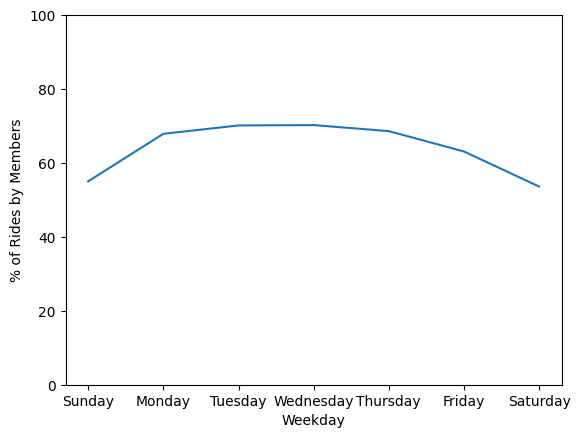

In [22]:
_df = by_weekday_chart.df()

p = sns.lineplot(y="member_pct", x="weekday", data=_df)
p.set_ylim(0, 100)
p.set_xlabel("Weekday")
p.set_ylabel("% of Rides by Members")
plt.show()

#### Year-round: Fitness habit.

While ridership drops dramatically in the colder months, the percentage of rides made by members increases dramatically. This could point to annual memberships as an incentive to year-round healthy behavior.

In [23]:
by_month_chart = con.sql("""
    WITH r AS (
        SELECT MONTH(started_at) monthnum,
            strftime(started_at, '%B') "month", 
            member_casual, 
            COUNT(ride_id) count
        FROM rides
        GROUP BY month(started_at), strftime(started_at, '%B'), member_casual
    ), p AS (
        PIVOT r ON member_casual USING SUM(count)
    )
    SELECT month, casual, member, (casual+member) total, 
        ROUND(member/(member+casual)*100, 1) member_pct FROM p
    ORDER BY monthnum
""")

by_month_chart

┌───────────┬────────┬────────┬────────┬────────────┐
│   month   │ casual │ member │ total  │ member_pct │
│  varchar  │ int128 │ int128 │ int128 │   double   │
├───────────┼────────┼────────┼────────┼────────────┤
│ January   │  39831 │ 150152 │ 189983 │       79.0 │
│ February  │  42841 │ 147301 │ 190142 │       77.5 │
│ March     │  61948 │ 196342 │ 258290 │       76.0 │
│ April     │ 146604 │ 279110 │ 425714 │       65.6 │
│ May       │ 233127 │ 370273 │ 603400 │       61.4 │
│ June      │ 299819 │ 418040 │ 717859 │       58.2 │
│ July      │ 329531 │ 435842 │ 765373 │       56.9 │
│ August    │ 309298 │ 459973 │ 769271 │       59.8 │
│ September │ 260376 │ 404321 │ 664697 │       60.8 │
│ October   │ 176231 │ 359620 │ 535851 │       67.1 │
│ November  │  97934 │ 263822 │ 361756 │       72.9 │
│ December  │  51397 │ 172184 │ 223581 │       77.0 │
├───────────┴────────┴────────┴────────┴────────────┤
│ 12 rows                                 5 columns │
└───────────────────────────

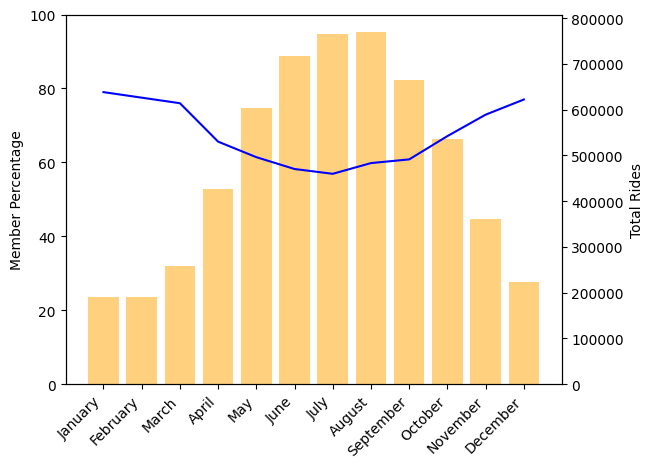

In [24]:
_df = by_month_chart.df()

fig, ax1 = plt.subplots()

# Line plot for member_pct
ax1.plot(_df['month'], _df['member_pct'], color='blue')
ax1.set_ylabel('Member Percentage')
ax1.set_ylim(0, 100)

# Bar plot for total
ax2 = ax1.twinx()
ax2.bar(_df['month'], _df['total'], color='orange', alpha=0.5)
ax2.set_ylabel('Total Rides')

# Move the line plot to the front
ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)

# Rotate x-axis labels at a 45-degree angle
ax1.set_xticks(range(len(_df['month'])))
ax1.set_xticklabels(_df['month'], rotation=45, ha='right')

plt.show()

#### Downtown: convenient, easily-bikeable, and an endpoint for commuters.

The map below shows the 50 stations with the highest percentage of rentals by members in blue, and the 50 stations with the highest percentage of rentals by casual users in red (this particular mapping API limits us to 100 markers total).

It's clear here that the blue stations (used most heavily by members), are concentrated in downtown Chicago. This implies that commuting to work is a significant use-case for annual members. Advertising annual memberships at these stations, and to casual users who repeatedly start or end trips in these areas, might be a winning strategy.

Most of the red stations re located on the shoreline and along the [Magnificent Mile](https://en.wikipedia.org/wiki/Magnificent_Mile), suggesting heavy tourist use in these areas. We're not likely to convert these users to annual memberships.

In [25]:
%%sql
DROP VIEW IF EXISTS v_notable_stations;
CREATE VIEW  v_notable_stations AS
WITH ride_counts_by_station_rider_type AS (
    SELECT start_station_name, start_lat, start_lng, member_casual, COUNT(*) count
        FROM rides
        GROUP BY start_station_name, start_lat, start_lng, member_casual
), ride_counts_by_station AS (
    PIVOT ride_counts_by_station_rider_type ON member_casual IN ('member', 'casual') USING SUM(count)
), pct_member_by_station AS (
    SELECT *, (casual+member) total, ROUND(member/(casual+member)*100, 2) pct_member 
    FROM ride_counts_by_station
    WHERE (casual+member) > 500
), most_members AS (
    SELECT *, 3 icon FROM pct_member_by_station ORDER BY pct_member DESC LIMIT 50
), least_members AS (
    SELECT *, 9 icon FROM pct_member_by_station ORDER BY pct_member LIMIT 50
) 
SELECT * FROM most_members UNION SELECT * FROM least_members;

SELECT * FROM v_notable_stations;

Running query in 'DuckDBPyConnection'

start_station_name,start_lat,start_lng,member,casual,total,pct_member,icon
None,41.84,-87.62,1815,194,2009,90.34,3
Hermitage Ave & Polk St,41.871514,-87.669886,2758,485,3243,85.04,3
May St & Taylor St,41.8694821,-87.6554864,6629,1201,7830,84.66,3
Wentworth Ave & 33rd St,41.83452988563,-87.6318229814,1706,363,2069,82.46,3
Emerald Ave & 28th St,41.84358,-87.645368,1623,353,1976,82.14,3
None,41.83,-87.61,996,218,1214,82.04,3
Campbell Ave & Montrose Ave,41.961524,-87.691177,1365,309,1674,81.54,3
Ogden Ave & Congress Pkwy,41.87501,-87.67328,1958,448,2406,81.38,3
None,41.87,-87.65,5110,1199,6309,81.0,3
None,41.87,-87.67,3243,765,4008,80.91,3


In [26]:
mapkeypath = Path('mapkey.txt')
mapkey = mapkeypath.open().read() if mapkeypath.exists() else False

if mapkey:
    url = f"https://dev.virtualearth.net/REST/v1/Imagery/Map/Road?mapsize=400,800&format=png&key={mapkey}"

    # Add pushpins to the request body
    pushpins = []
    stations = con.sql("SELECT * FROM v_notable_stations")
    while True:
        station = stations.fetchone()
        if station is None:
            break
        pushpins.append(f"pp={station[1]},{station[2]};{station[-1]};")

    # Add remaining parameters to the URL
    #url += f"mapSize=500,500&format=png&pushpins={pushpins}

    response = requests.post(url, data="&".join(pushpins))

    with open("map.png", "wb") as f:
        f.write(response.content)

![Map of Chicago with the most and least member-used stations makred in blue and red, respectively](map.png)

In [27]:
con.close()